# Forecasting 

![extrapolating](https://imgs.xkcd.com/comics/extrapolating.png)

In this lesson, we will practice forecasting using the following methods:  

- Last observed value  
- Simple average  
- Moving average  
- Holt's Linear Trend  
- Previous cycle  


______________________________


We will walk through steps from previous lessons to get the data ready to model

- Acquire data: prepare.acquire_store_data()  
- Prepare data: prepare.prep_store_data()  
- Split data: prepare.split_store_data()  

Then we will forecast and evaluate using each method. 

## Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

import env
import acquire
import prepare

## Acquire

We will acquire the store-item-demand data for this lesson from the sql database. 

In [2]:
# define get_connection
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return(f'mysql+pymysql://{user}:{password}@{host}/{db}')

In [3]:
#assign query to variable
query = acquire.query

In [4]:
# read sql query using pd.read_sql()
df = pd.read_sql(query, get_connection("tsa_item_demand"))

In [5]:
# take a peak
df.head()

,sale_id,sale_date,store_id,item_id,sale_amount,store_id,store_address,store_zipcode,store_city,store_state,item_id,item_upc14,item_upc12,item_brand,item_name,item_price
0,1,2013-01-01,1,1,13,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84
1,2,2013-01-02,1,1,11,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84
2,3,2013-01-03,1,1,14,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84
3,4,2013-01-04,1,1,13,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84
4,5,2013-01-05,1,1,10,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84


## Prepare


1. sale_date to datetime
2. sort values by date
3. set index
4. new field: dollars_sold = sale_amount * item_price
5. rename sale_amount to items_sold to make the two columns easier to understand what the data represents. 
6. resample daily (The original granularity is daily, but there are multiple records of the same days across multiple stores.)
7. remove leap days!

In [6]:
'''
# sale_date to datetime
df['sale_date']=pd.to_datetime(df.sale_date)
# sort values by date
df.sort_values('sale_date',inplace = True)
# set index
df.set_index('sale_date',inplace = True)
# create dollars_sold = sale_amount * item_price
df['dollars_sold'] = df.sale_amount * df.item_price
# create items_sold from sale_amount (rename)
df.rename(columns = {'sale_amount': 'items_sold'},inplace = True)
# resample daily, summing dollars_sold and items_sold
df['dollars_sold_daily'] = df.resample('D').dollars_sold.sum()
df['items_sold_daily'] = df.resample('D').items_sold.sum()
# remove leap days
'''

"\n# sale_date to datetime\ndf['sale_date']=pd.to_datetime(df.sale_date)\n# sort values by date\ndf.sort_values('sale_date',inplace = True)\n# set index\ndf.set_index('sale_date',inplace = True)\n# create dollars_sold = sale_amount * item_price\ndf['dollars_sold'] = df.sale_amount * df.item_price\n# create items_sold from sale_amount (rename)\ndf.rename(columns = {'sale_amount': 'items_sold'},inplace = True)\n# resample daily, summing dollars_sold and items_sold\ndf['dollars_sold_daily'] = df.resample('D').dollars_sold.sum()\ndf['items_sold_daily'] = df.resample('D').items_sold.sum()\n# remove leap days\n"

In [7]:
df.head(1)

,sale_id,sale_date,store_id,item_id,sale_amount,store_id,store_address,store_zipcode,store_city,store_state,item_id,item_upc14,item_upc12,item_brand,item_name,item_price
0,1,2013-01-01,1,1,13,1,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84


In [8]:
df.tail(1)

,sale_id,sale_date,store_id,item_id,sale_amount,store_id,store_address,store_zipcode,store_city,store_state,item_id,item_upc14,item_upc12,item_brand,item_name,item_price
912999,913000,2017-12-31,10,50,82,10,8503 NW Military Hwy,78231,San Antonio,TX,50,47445919221,47445919221,Choice,Choice Organic Teas Black Tea Classic Black - ...,5.2


In [9]:
df = acquire.get_sales_data()

In [10]:
'''
# notes
# sale_date to datetime
# sort values by date
df = df.assign(ds = pd.to_datetime(df.sale_date)).sort_values('ds')
# set index
#df.set_index('ds')
# create dollars_sold = sale_amount * item_price
df['dollars_sold'] = df.sale_amount * df.item_price
# create items_sold from sale_amount (rename)
df.assign(items_sold = df.sale_amount)
# resample daily, summing dollars_sold and items_sold
df = df.groupby(['ds'])[['dollars_sold','items_sold']].sum()
df.set_index('ds')
# remove leap days
'''

"\n# notes\n# sale_date to datetime\n# sort values by date\ndf = df.assign(ds = pd.to_datetime(df.sale_date)).sort_values('ds')\n# set index\n#df.set_index('ds')\n# create dollars_sold = sale_amount * item_price\ndf['dollars_sold'] = df.sale_amount * df.item_price\n# create items_sold from sale_amount (rename)\ndf.assign(items_sold = df.sale_amount)\n# resample daily, summing dollars_sold and items_sold\ndf = df.groupby(['ds'])[['dollars_sold','items_sold']].sum()\ndf.set_index('ds')\n# remove leap days\n"

In [11]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.sale_date)).sort_values('ds').\
            assign(dollars_sold = df.sale_amount * df.item_price).\
            assign(items_sold = df.sale_amount).\
            groupby(['ds'])[['dollars_sold','items_sold']].sum()

In [12]:
df = prep_data(df)
df = df[df.index != '2016-02-29']

In [13]:
df.head(1)

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2013-01-01 00:00:00+00:00 to 2017-12-31 00:00:00+00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dollars_sold  1825 non-null   float64
 1   items_sold    1825 non-null   float64
dtypes: float64(2)
memory usage: 42.8 KB


We will resample to daily, but essentially what we are doing is grouping by the day and aggregating using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores. 

## Split

1. We will use the training proportion method to split.    
2. Identify the total length of the dataframe and multiple by `train_prop` to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.   (`x = train_prop * 100`)  
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.  
4. Return train and test dataframes.  

In [15]:
len(df)

1825

In [16]:
# compute num of rows that are 50% of total rows and assign to variable train_size
train_size = int(len(df) * .5)
train_size

912

In [17]:
# compute num of rows that are 30% of total rows and assign to variable validate_size
validate_size = int(len(df) * .3)
validate_size

547

In [18]:
# make test_size the number of rows remaining (test_size = total # of rows - train_size - validate_size)
test_size = int(len(df) - train_size - validate_size)
test_size

366

In [19]:
train_size + validate_size + test_size == len(df)

True

In [20]:
# compute the row number at which the switch from validate to test happens. 
validate_end_index = train_size + validate_size

In [21]:
# split into train, validation, test
train = df[: train_size]

In [22]:
validate = df[train_size: validate_end_index]

In [23]:
test = df[validate_end_index:]

In [24]:
test.tail()

,dollars_sold,items_sold
ds,,
2017-12-27 00:00:00+00:00,109151.15,20378.0
2017-12-28 00:00:00+00:00,117377.49,21885.0
2017-12-29 00:00:00+00:00,126541.84,23535.0
2017-12-30 00:00:00+00:00,134903.07,24988.0
2017-12-31 00:00:00+00:00,140905.74,26420.0


**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [25]:
# sum of train, validate and test = total number of rows? 
len(train) + len(validate) + len(test) == len(df)

True

Does the first row of original df equate to the first row of train? 

In [26]:
# test the row starts
print(df.head(1) == train.head(1))

                           dollars_sold  items_sold
ds                                                 
2013-01-01 00:00:00+00:00          True        True


Is the last row of train the day before the first row of validate? And the same for validate to test? 

In [27]:
# test the split between validate and test
pd.concat([train.tail(1),validate.head(1)])

,dollars_sold,items_sold
ds,,
2015-07-01 00:00:00+00:00,164573.20,30703.0
2015-07-02 00:00:00+00:00,178036.64,33134.0


In [28]:
pd.concat([validate.tail(1),test.head(1)])

,dollars_sold,items_sold
ds,,
2016-12-30 00:00:00+00:00,120033.64,22296.0
2016-12-31 00:00:00+00:00,128009.31,23792.0


Is the last row of test the same as the last row of our original dataframe? 

In [29]:
# compare the last row of test to last row of df
pd.concat([test.tail(1),df.tail(1)])

,dollars_sold,items_sold
ds,,
2017-12-31 00:00:00+00:00,140905.74,26420.0
2017-12-31 00:00:00+00:00,140905.74,26420.0


Let's plot our data first, viewing where the data is split into train, validate, and test. 

In [30]:
def plot_samples(target_var):
    '''
    this function will plot the train, validate, and test given a target var
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var])
    plt.plot(validate[target_var])
    plt.plot(test[target_var])
    plt.title(f'{target_var}')

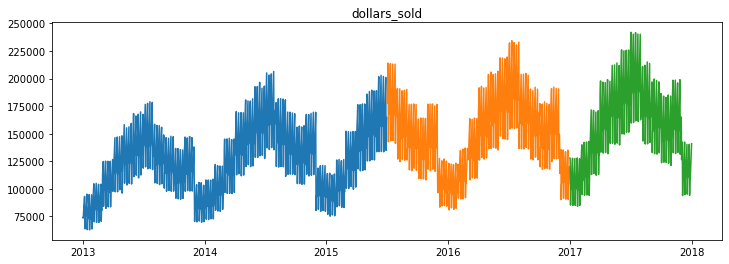

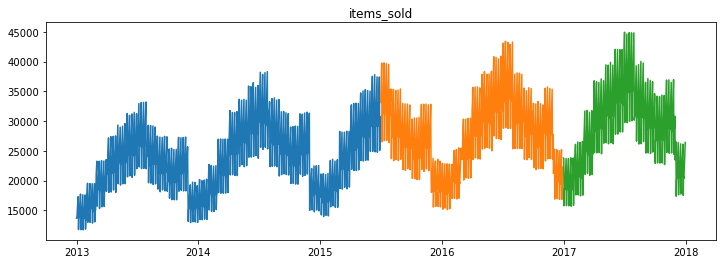

In [31]:
# plot the data points, color by train, validate, test
for col in train.columns:
    plot_samples(col)
    
plt.show()

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow. 

`evaluate()` will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.  

In [32]:
# define evaluation function to compute rmse

def evaluate(target_var):
    '''
    the evaluate function will take in the actual values in validate and the predicted values
    and compute the mean_squared_error and then take the square root and round to 0 decimals.
    it will return the rmse, print rmse, an int.
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var],yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to compare performance. 

In [33]:
# plot and evaluate: plot
def plot_and_eval(target_var):
    '''
    a function to evaluate forecasts by computing the rmse and plot train and validate along with predictions
    '''
    plot_samples(target_var)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var,'--RMSE: {:.0f}'.format(rmse))
    plt.show()

Write `append_eval_df(model_type)` to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our `eval_df` data frame object. Which we will create an empty `eval_df` dataframe object to start. 

In [34]:
# Create the empty dataframe with model_type, target_var, rmse
eval_df = pd.DataFrame(columns = ['model_type','target_var','RMSE'])

In [35]:
# check out the data frame
eval_df

,model_type,target_var,RMSE


In [36]:
# Define function to store rmse for comparison purposes

def append_eval_df(model_type,target_var):
    '''
    this finction is going to take in the model_type as a string, the target var as a string,
    and run the evaluate() function to compute the rmse,
    and append the data frame a row with the model_type, target_var, and rmse
    it will return the new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'RMSE' : [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d,ignore_index = True)
    

## Forecast 
- Last observed value
- Simple average
- Moving average
- Holt's linear treant
- Previous cycle
### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

In [37]:
train.head()

,dollars_sold,items_sold
ds,,
2013-01-01 00:00:00+00:00,73844.01,13696.0
2013-01-02 00:00:00+00:00,73570.58,13678.0
2013-01-03 00:00:00+00:00,78169.48,14488.0
2013-01-04 00:00:00+00:00,84467.73,15677.0
2013-01-05 00:00:00+00:00,87621.85,16237.0


In [38]:
# create var 'items' with last observed value
items = train['items_sold'][-1]
items

30703.0

In [39]:
# create dollars 'items' with last observed value
dollars = round(train['dollars_sold'][-1],2)
dollars

164573.2

In [40]:
# make predictions by adding those values to new dataframe yhat_df
yhat_df = pd.DataFrame({'items_sold': [items], 'dollars_sold': [dollars]},index = validate.index)

yhat_df.head(5)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,30703.0,164573.2
2015-07-03 00:00:00+00:00,30703.0,164573.2
2015-07-04 00:00:00+00:00,30703.0,164573.2
2015-07-05 00:00:00+00:00,30703.0,164573.2
2015-07-06 00:00:00+00:00,30703.0,164573.2


You can see, when peeking into yhat_df, that every predicted value is the same.  

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values

dollars_sold --RMSE: 35402


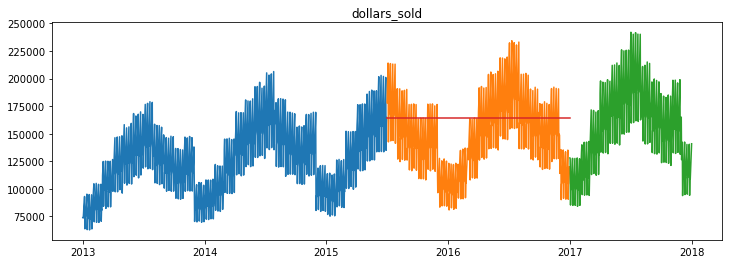

items_sold --RMSE: 6621


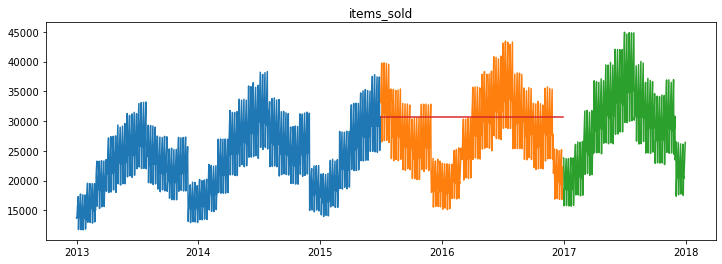

In [41]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [42]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)
    

In [43]:
eval_df

,model_type,target_var,RMSE
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0


### Simple Average

Take the simple average of historical values and use that value to predict future values.   

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train. 

**Make Predictions**

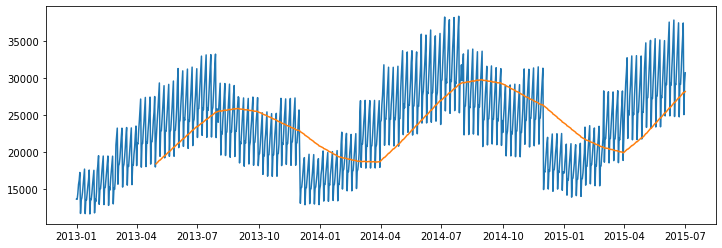

In [44]:
plt.figure(figsize=(12,4))
plt.plot(train['items_sold'])
plt.plot(train['items_sold'].rolling(120).mean())

In [45]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold':[items],'dollars_sold':[dollars]},index = validate.index)
    return yhat_df

In [46]:
yhat_df = make_predictions()

In [47]:
yhat_df.head(2)

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,23717.94,127517.85
2015-07-03 00:00:00+00:00,23717.94,127517.85


In [ ]:
items = round(train['items_sold'].mean(), 2)
dollars = round(train['dollars_sold'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'items_sold':[items],'dollars_sold':[dollars]},index = validate.index)
    return yhat_df
yhat_df = make_predictions()

**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

dollars_sold --RMSE: 39664


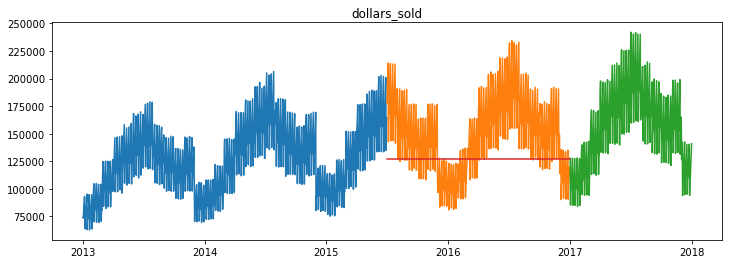

items_sold --RMSE: 7378


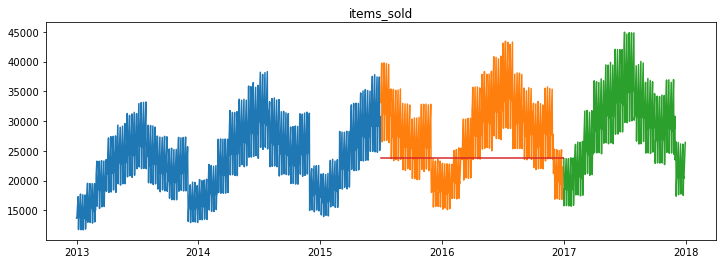

In [48]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [49]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', target_var = col)

In [50]:
eval_df

,model_type,target_var,RMSE
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0


### Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

**Make Predictions**

In [51]:
period = 30
items = round(train['items_sold'].rolling(period).mean().iloc[-1])
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1])

In [52]:
def make_predictions():
    yhat_df = pd.DataFrame({'items_sold':[items],'dollars_sold':[dollars]},index = validate.index)
    return yhat_df

In [53]:
yhat_df = make_predictions()

**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

dollars_sold --RMSE: 37378


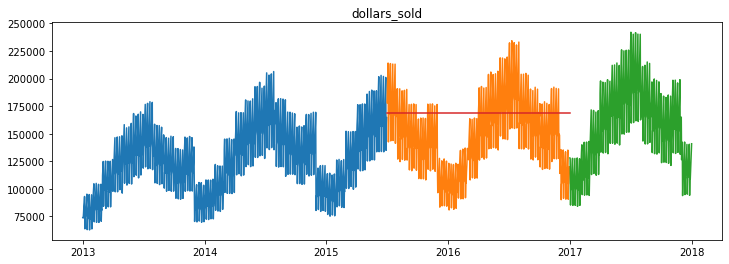

items_sold --RMSE: 6954


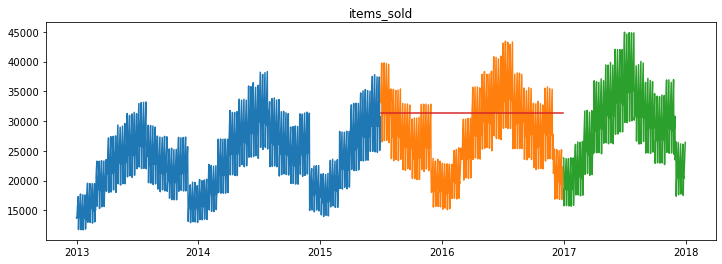

In [54]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [55]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'moving_average_30', target_var = col)
eval_df

,model_type,target_var,RMSE
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,moving_average_30,dollars_sold,37378.0
5,moving_average_30,items_sold,6954.0


In [56]:
period = 90
items = round(train['items_sold'].rolling(period).median().iloc[-1])
dollars = round(train['dollars_sold'].rolling(period).median().iloc[-1])

In [57]:
def make_predictions():
    yhat_df = pd.DataFrame({'items_sold':[items],'dollars_sold':[dollars]},index = validate.index)
    return yhat_df

In [58]:
yhat_df = make_predictions()

dollars_sold --RMSE: 33190


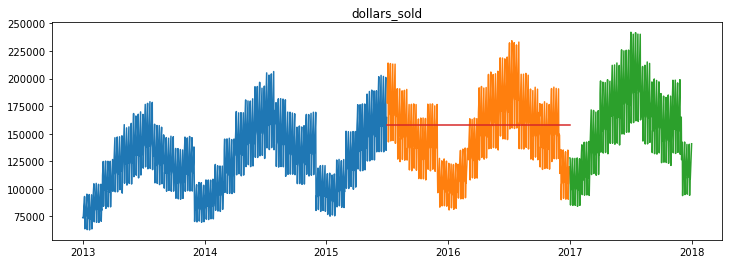

items_sold --RMSE: 6176


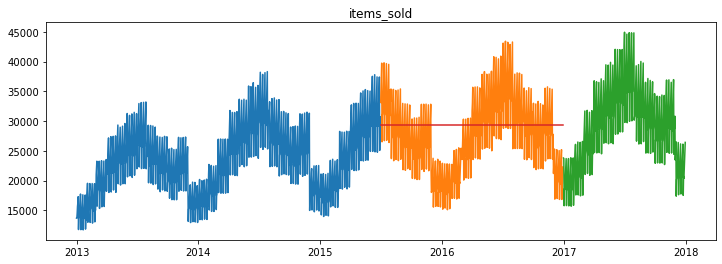

In [59]:
for col in train.columns:
    plot_and_eval(col)

In [60]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'moving_median_90', target_var = col)
eval_df

,model_type,target_var,RMSE
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,moving_average_30,dollars_sold,37378.0
5,moving_average_30,items_sold,6954.0
6,moving_average_90,dollars_sold,33190.0
7,moving_average_90,items_sold,6176.0


Let's try out several other values for periods:

In [61]:
period = 180
items = round(train['items_sold'].rolling(period).mean().iloc[-1])
dollars = round(train['dollars_sold'].rolling(period).mean().iloc[-1])

In [62]:
def make_predictions():
    yhat_df = pd.DataFrame({'items_sold':[items],'dollars_sold':[dollars]},index = validate.index)
    return yhat_df

In [63]:
yhat_df = make_predictions()

dollars_sold --RMSE: 35901


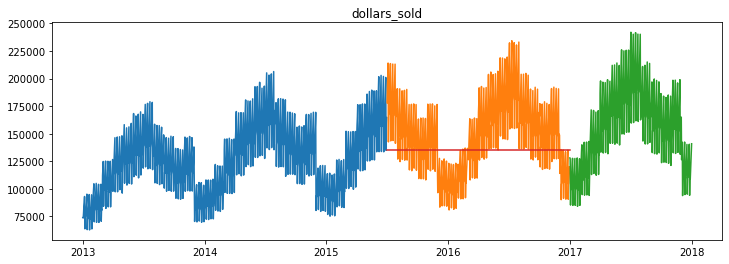

items_sold --RMSE: 6678


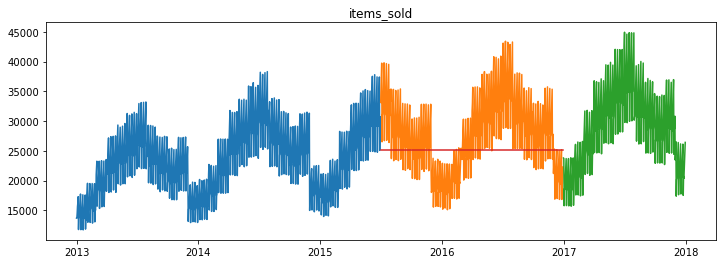

In [64]:
for col in train.columns:
    plot_and_eval(col)

In [65]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'moving_average_180', target_var = col)
eval_df

,model_type,target_var,RMSE
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,moving_average_30,dollars_sold,37378.0
5,moving_average_30,items_sold,6954.0
6,moving_average_90,dollars_sold,33190.0
7,moving_average_90,items_sold,6176.0
8,moving_average_180,dollars_sold,35901.0
9,moving_average_180,items_sold,6678.0


Which is best so far? 

In [66]:
# get the min rmse for each variable

In [71]:
# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df.sort_values(by = ['RMSE']).groupby('target_var').first()

,model_type,RMSE
target_var,,
dollars_sold,moving_average_90,33190.0
items_sold,moving_average_90,6176.0


### Holt's Linear Trend

Exponential smoothing applied to both the average and the trend (slope).  

- $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.   
- $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values. 


**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target. 

dollars_sold 



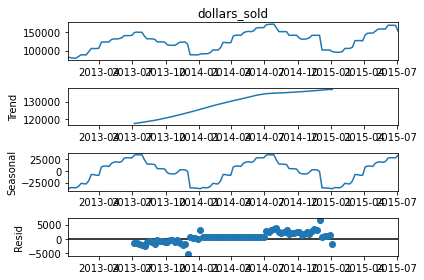

items_sold 



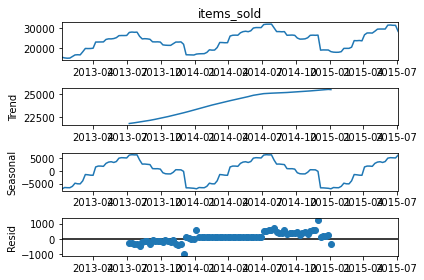

In [73]:
import statsmodels.api as sm
_ = sm.tsa.seasonal_decompose(train['amount']).plot()
plt.show()

#### Basic Holt's Linear Trend

**Make Predictions**

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions. 

Holt: 

- exponential = True/False (exponential vs. linear growth, additive vs. multiplicative)

fit: 

- smoothing_level ($\alpha$): value between (0,1)
- smoothing_slope ($\beta$): value between (0,1)

In [116]:
for col in train.columns: 
    model = Holt(train[col], exponential = False)
    # fit the model providing the alpha/ smoothing level and beta/smoothing slope
    model = model.fit(smoothing_level = .09,
                     smoothing_slope = .093,
                     optimized = False)

    # predict/forecast providing the start and end dates
    yhat = model.predict(start = validate.index[0], end = validate.index[-1])

    yhat_df[col] = round(yhat, 2)

In [117]:
yhat_df.head()

,items_sold,dollars_sold
ds,,
2015-07-02 00:00:00+00:00,31767.46,170747.05
2015-07-03 00:00:00+00:00,31769.34,170757.97
2015-07-04 00:00:00+00:00,31771.22,170768.90
2015-07-05 00:00:00+00:00,31773.10,170779.83
2015-07-06 00:00:00+00:00,31774.98,170790.75


**Plot Actual vs. Predicted Values**

dollars_sold --RMSE: 39868


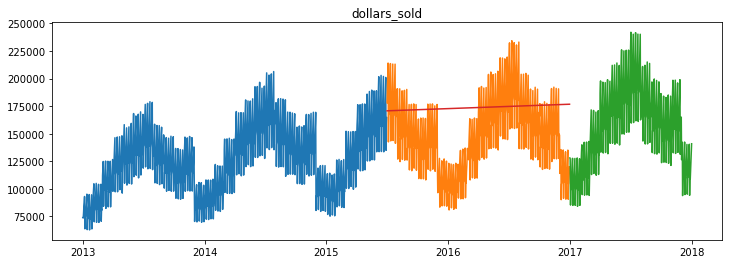

items_sold --RMSE: 7395


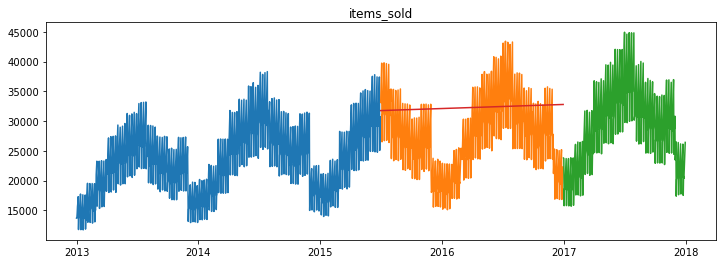

In [118]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', target_var = col)
    plot_and_eval(target_var = col)

**Evaluate**

In [119]:
eval_df

,model_type,target_var,RMSE
0,last_observed_value,dollars_sold,35402.0
1,last_observed_value,items_sold,6621.0
2,simple_average,dollars_sold,39664.0
3,simple_average,items_sold,7378.0
4,moving_average_30,dollars_sold,37378.0
5,moving_average_30,items_sold,6954.0
6,moving_average_90,dollars_sold,33190.0
7,moving_average_90,items_sold,6176.0
8,moving_average_180,dollars_sold,35901.0
9,moving_average_180,items_sold,6678.0


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [120]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

**Make Predictions**

In [124]:
# take the values for each day in 2015 and add the average yoy (y/y) difference to be our forecast for 2016.
yhat_df = train['2015'] + train.diff(365).mean()

In [126]:
# set yhat_df to index of validate
yhat_df = yhat_df.set_index(validate.index)

In [127]:
yhat_df.head()

,dollars_sold,items_sold
ds,,
2016-01-01 00:00:00+00:00,104337.620493,19411.813699
2016-01-02 00:00:00+00:00,112870.770493,20904.813699
2016-01-03 00:00:00+00:00,118245.300493,21983.813699
2016-01-04 00:00:00+00:00,125496.760493,23286.813699
2016-01-05 00:00:00+00:00,88551.940493,16420.813699


**Plot and Evaluate**

dollars_sold --RMSE: 28087


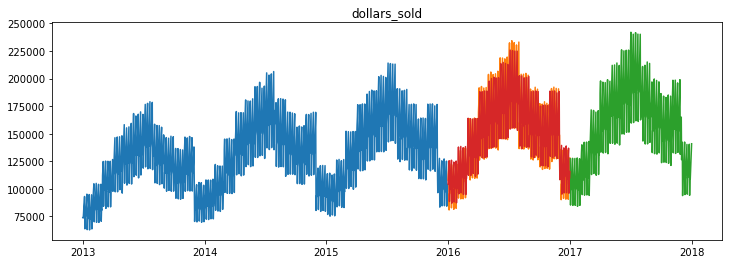

items_sold --RMSE: 5223


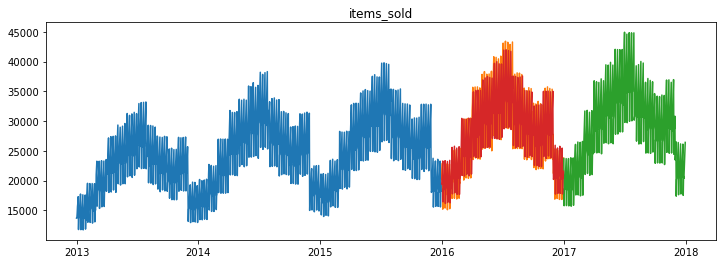

In [128]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'yoy-diff', target_var = col)
    plot_and_eval(target_var = col)

In [138]:
'''
pd.concat([yhat_df.items_sold, validate.items_sold], axis = 1)
compare_df.columns = ['yhat_items', 'actual_items']
compare_df['error'] = compare_df.actual_items - compare_df.yhat_items
compare_df['squared_error'] = compare_df.error * compare_df.error
compare_df['mean_squared_error'] = compare_df.squared_error.mean()
sqrt(compare_df.squared_error.mean())
'''

"\npd.concat([yhat_df.items_sold, validate.items_sold], axis = 1)\ncompare_df.columns = ['yhat_items', 'actual_items']\ncompare_df['error'] = compare_df.actual_items - compare_df.yhat_items\ncompare_df['squared_error'] = compare_df.error * compare_df.error\ncompare_df['mean_squared_error'] = compare_df.squared_error.mean()\nsqrt(compare_df.squared_error.mean())\n"

In [135]:
eval_df.sort_values('RMSE').groupby('target_var').first()

,model_type,RMSE
target_var,,
dollars_sold,yoy-diff,28087.0
items_sold,yoy-diff,5223.0


## Conclusion

Which model did the best? 

In [69]:
# get the min rmse for each variable


# filter only the rows that match those rmse to find out 
# which models are best thus far


Let's test it out on our out-of-sample data

We will be using train + validate to predict test. 

In [139]:
# must use the same parameters we used from train
yhat = validate + train.diff(365).mean()
# set index to that of test
yhat_df.index = test.index

dollars_sold --RMSE: 28087


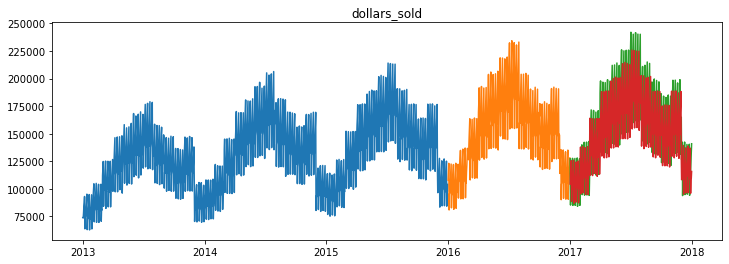

items_sold --RMSE: 5223


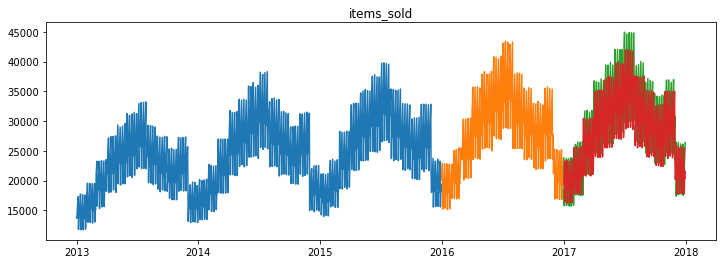

In [140]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'yoy-diff-test', target_var = col)
    plot_and_eval(target_var = col)

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.

In [365]:
df = pd.read_csv('saas.csv')

In [366]:
df.Amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: Amount, dtype: int64

In [367]:
df.Subscription_Type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: Subscription_Type, dtype: int64

In [368]:
df.drop(columns = ['Customer_Id','Invoice_Id','Subscription_Type'],inplace = True)

In [369]:
def prep_data(df):
    return df.assign(ds = pd.to_datetime(df.Month_Invoiced)).sort_values('ds').\
            groupby(['ds'])[['Amount']].sum()

In [370]:
df = prep_data(df)

In [371]:
df.head()

,Amount
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [372]:
df.rename(columns = {'Amount':'amount'},inplace = True)

<AxesSubplot:xlabel='ds'>

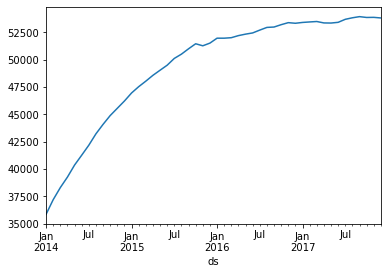

In [373]:
df.amount.plot()

In [374]:
df.tail()

,amount
ds,
2017-08-31,53820.0
2017-09-30,53925.0
2017-10-31,53850.0
2017-11-30,53860.0
2017-12-31,53805.0


In [375]:
df.shape

(48, 1)

In [376]:
train_size = int(len(df) * .5)
train_size

24

In [377]:
validate_size = int(len(df) * .3)
validate_size

14

In [378]:
test_size = int(len(df) - train_size - validate_size)
test_size

10

In [379]:
validate_end_index = train_size + validate_size

In [380]:
train = df[: train_size]
validate = df[train_size: validate_end_index]
test = df[validate_end_index:]

In [381]:
train.tail(1)

,amount
ds,
2015-12-31,51505.0


In [382]:
validate.head(1)

,amount
ds,
2016-01-31,51955.0


In [383]:
validate.tail(1)

,amount
ds,
2017-02-28,53440.0


In [384]:
test.head(1)

,amount
ds,
2017-03-31,53480.0


In [385]:
len(df) == train_size + validate_size + test_size

True

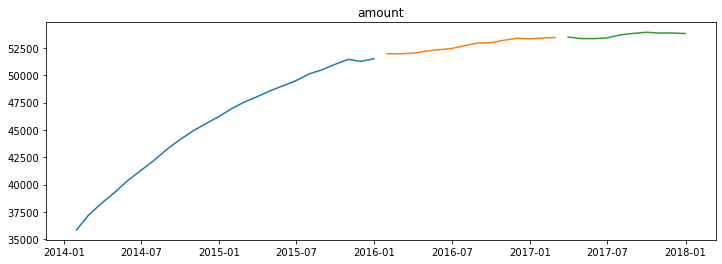

In [386]:
plot_samples('amount')
    
plt.show()

In [387]:
def append_eval_df(model_type,target_var):
    '''
    this finction is going to take in the model_type as a string, the target var as a string,
    and run the evaluate() function to compute the rmse,
    and append the data frame a row with the model_type, target_var, and rmse
    it will return the new dataframe
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'RMSE' : [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d,ignore_index = True)

In [388]:
eval_df = pd.DataFrame(columns = ['model_type','target_var','RMSE'])

# SIMPLE AVERAGE

In [389]:
amount = round(train['amount'].mean(), 2)

def make_predictions():
    yhat_df = pd.DataFrame({'amount':[amount]},index = validate.index)
    return yhat_df
yhat_df = make_predictions()

amount --RMSE: 7181


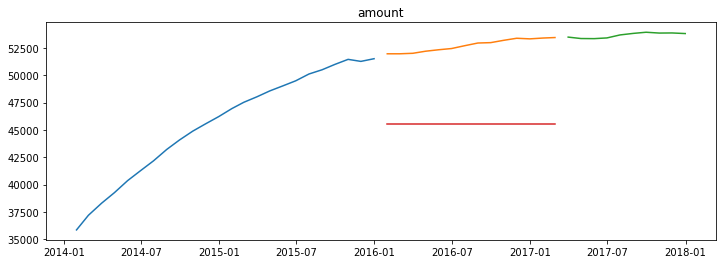

In [390]:
plot_and_eval('amount')

In [391]:
eval_df = append_eval_df(model_type = 'simple_average', target_var = 'amount')
eval_df

,model_type,target_var,RMSE
0,simple_average,amount,7181.0


# Moving Average

In [392]:
period = 3
amount = round(train['amount'].rolling(period).mean().iloc[-1])

In [393]:
yhat_df = make_predictions()

amount --RMSE: 1436


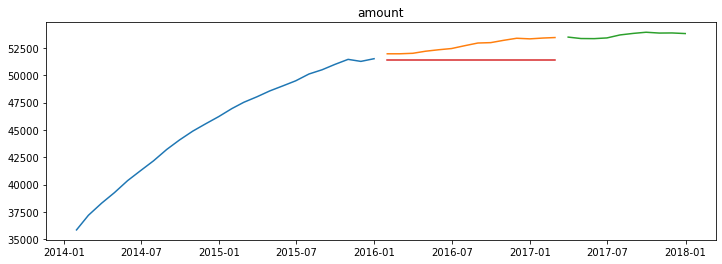

In [394]:
plot_and_eval('amount')

In [395]:
eval_df = append_eval_df(model_type = 'moving_average_3', target_var = 'amount')
eval_df

,model_type,target_var,RMSE
0,simple_average,amount,7181.0
1,moving_average_3,amount,1436.0


# Holt's Linear Trend Model

In [426]:
model = Holt(train['amount'], exponential = False)
# fit the model providing the alpha/ smoothing level and beta/smoothing slope
model = model.fit(smoothing_level = .95,
                     smoothing_slope = .95,
                     optimized = True)

# predict/forecast providing the start and end dates
yhat = model.predict(start = validate.index[0], end = validate.index[-1])

yhat_df['amount'] = round(yhat, 2)

amount --RMSE: 148


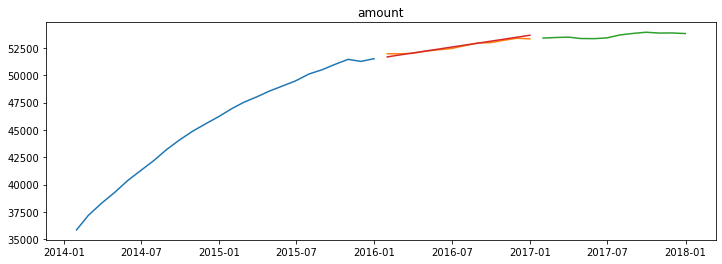

In [427]:
eval_df = append_eval_df(model_type = 'Holts', target_var = 'amount')
plot_and_eval(target_var = 'amount')

In [398]:
eval_df

,model_type,target_var,RMSE
0,simple_average,amount,7181.0
1,moving_average_3,amount,1436.0
2,Holts,amount,8792.0


In [399]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [407]:
train

,amount
ds,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0
2014-06-30,41255.0
2014-07-31,42170.0
2014-08-31,43210.0
2014-09-30,44075.0


In [410]:
train.diff(4)

,amount
ds,
2014-01-31,NaN
2014-02-28,NaN
2014-03-31,NaN
2014-04-30,NaN
2014-05-31,4505.0
2014-06-30,4065.0
2014-07-31,3875.0
2014-08-31,3955.0
2014-09-30,3720.0


In [400]:
yhat_df = train['2015'] + train.diff(4).mean()

In [401]:
yhat_df = yhat_df.set_index(validate.index)

In [402]:
yhat_df

,amount
ds,
2016-01-31,49675.25
2016-02-29,50250.25
2016-03-31,50755.25
2016-04-30,51290.25
2016-05-31,51755.25
2016-06-30,52215.25
2016-07-31,52835.25
2016-08-31,53225.25
2016-09-30,53715.25


amount --RMSE: 1067


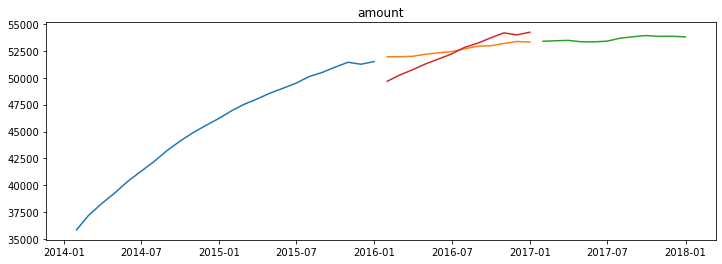

In [403]:
eval_df = append_eval_df(model_type = 'yoy-diff', target_var = 'amount')
plot_and_eval(target_var = 'amount')

In [404]:
eval_df

,model_type,target_var,RMSE
0,simple_average,amount,7181.0
1,moving_average_3,amount,1436.0
2,Holts,amount,8792.0
3,yoy-diff,amount,1067.0


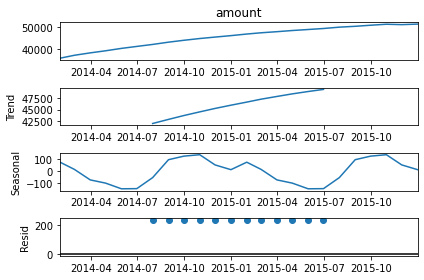

In [405]:
_ = sm.tsa.seasonal_decompose(train['amount']).plot()
plt.show()